In [ ]:
#!pip install scikit-learn --upgrade
#!pip install tensorflow --upgrade
#!pip install scikeras

!pip install scikit-learn==1.3.0
!pip install tensorflow==2.13.0
!pip install scikeras==0.10.1

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-01-01 to 2024-12-31
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Daily_using    366 non-null    float64
 1   Standard       366 non-null    float64
 2   Nearline       366 non-null    float64
 3   Coldline       366 non-null    float64
 4   Archive        366 non-null    float64
 5   Single_sum     366 non-null    float64
 6   Single_cost    366 non-null    float64
 7   Total_Usage    366 non-null    float64
 8   Standard_Cost  366 non-null    float64
 9   Nearline_Cost  366 non-null    float64
 10  Coldline_Cost  366 non-null    float64
 11  Archive_Cost   366 non-null    float64
 12  Multi_sum      366 non-null    float64
 13  Multi_cost     366 non-null    float64
dtypes: float64(14)
memory usage: 42.9 KB


None

            Daily_using   Standard  Nearline  Coldline    Archive  Single_sum  \
Date                                                                            
2024-01-01    40.581311   6.858242  3.327668  0.811626  29.218544   40.581311   
2024-01-02    95.317859  16.108718  7.816064  1.906357  68.628859  135.899170   
2024-01-03    74.539424  12.597163  6.112233  1.490788  53.668386  210.438595   
2024-01-04    61.872556  10.456462  5.073550  1.237451  44.548240  272.311151   
2024-01-05    19.821771   3.349879  1.625385  0.396435  14.271675  292.132922   
2024-01-06    19.819479   3.349492  1.625197  0.396390  14.270025  311.952401   
2024-01-07    10.517943   1.777532  0.862471  0.210359   7.572919  322.470344   
2024-01-08    87.286734  14.751458  7.157512  1.745735  62.846448  409.757078   
2024-01-09    62.105926  10.495902  5.092686  1.242119  44.716267  471.863004   
2024-01-10    72.266895  12.213105  5.925885  1.445338  52.032164  544.129899   

            Single_cost  To

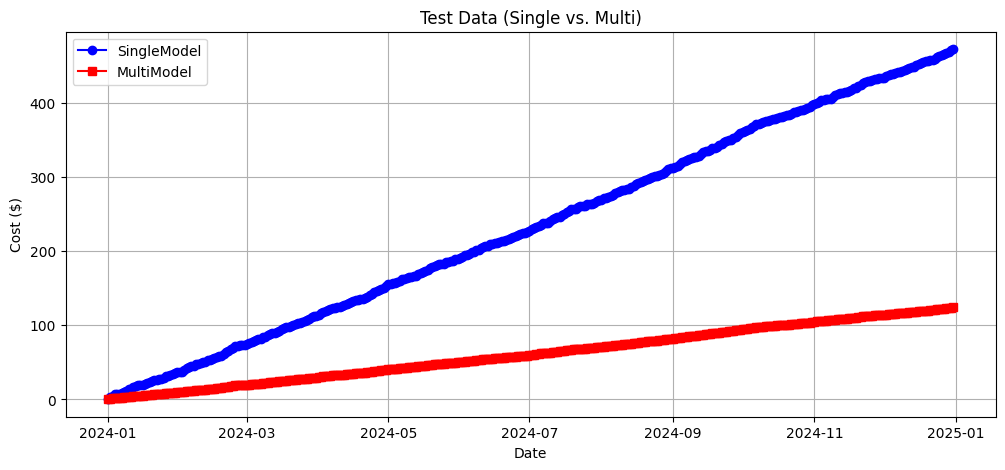

The storage cost for past 1 year 
 - Single model:$472.77682384787045
 - Multi  model:$124.15119394245085


In [6]:
# 데이터 준비 비율적용

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# 데이터 설정
storage_costs = {'Standard': 0.025, 'Nearline': 0.010, 'Coldline': 0.004, 'Archive': 0.002}

# 스토로지 저장 비율 설정
storage_ratios = {'Standard': 0.169, 'Nearline': 0.082, 'Coldline': 0.02, 'Archive': 0.72}


# 날짜 생성
year = 2024
dates = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31")

# 샘플 데이터 생성
np.random.seed(42)
storage = pd.DataFrame({'Daily_using': np.random.uniform(5, 100, size=len(dates))})
storage['Date'] = dates

# 각 계층별 데이터 분배
for tier, ratio in storage_ratios.items():
    storage[tier] = storage['Daily_using'] * ratio

# 샘플 데이터 생성 (단일모델)
storage['Single_sum'] = storage['Daily_using'].cumsum()
storage['Single_cost'] = storage['Single_sum'] * storage_costs['Standard']

# 샘플 데이터 생성 (복합모델)
storage['Total_Usage'] = storage[list(storage_ratios.keys())].sum(axis=1)
for tier in storage_ratios.keys():
    storage[f'{tier}_Cost'] = storage[tier] * storage_costs[tier]
    storage[f'{tier}_Cost'] = storage[f'{tier}_Cost'].cumsum()

# 일별 누적 사용량 및 비용 계산
storage['Multi_sum'] = storage['Total_Usage'].cumsum()
storage['Multi_cost'] = sum(storage[f'{tier}_Cost'] for tier in storage_ratios.keys())
storage.set_index('Date', inplace=True)


# 결과 출력
display(storage.info())
print(storage.head(10))


# 데이터 시각화
plt.figure(figsize=(12, 5))
plt.plot(storage.index, storage['Single_cost'], label='SingleModel', marker='o', color='blue')
plt.plot(storage.index, storage['Multi_cost'], label='MultiModel', marker='s', linestyle='-', color='red')
plt.xlabel('Date')
plt.xlabel('Date')
plt.ylabel('Cost ($)')
plt.title('Test Data (Single vs. Multi)')
plt.legend()
plt.grid()
plt.show()

print(f"The storage cost for past 1 year \n - Single model:${storage['Single_cost'].iloc[-1]}\n - Multi  model:${storage['Multi_cost'].iloc[-1]}")


In [ ]:
# 데이터 정규화
# 단일모델
data = pd.DataFrame({'TotalCost': storage['Single_cost']})
#복합모델
#data = pd.DataFrame({'TotalCost': storage['Multi_cost']})

data['Diff'] = data['TotalCost'].diff().fillna(0)
display(data.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-01-01 to 2024-12-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TotalCost  366 non-null    float64
 1   Diff       366 non-null    float64
dtypes: float64(2)
memory usage: 8.6 KB


None

In [14]:
# LSTM 모델 학습
look_back = 90
forecast_steps =  5 * 365 # 60
budget = 800

# 데이터 정규화
# 단일모델
data = pd.DataFrame({'TotalCost': storage['Single_cost']})
data['Diff'] = data['TotalCost'].diff().fillna(0)
display(data.info())

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Diff']])

# LSTM 입력 데이터 준비 함수
def create_lstm_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X, y = create_lstm_dataset(data_scaled, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# 모델 정의
model = Sequential([
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(look_back, 1)),
    Dropout(0.3),
    LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=1e-4, verbose=1)

# 학습 실행
history = model.fit(X, y, epochs=100, batch_size=16, verbose=0, validation_split=0.2, callbacks=[early_stopping])

# 예측 데이터 생성
X_forecast = data_scaled[-look_back:]
X_forecast = np.reshape(X_forecast, (1, look_back, 1))

forecast_scaled = []
for _ in range(forecast_steps):
    next_step = model.predict(X_forecast, verbose=0)
    forecast_scaled.append(next_step[0, 0])
    X_forecast = np.append(X_forecast[:, 1:, :], next_step.reshape(1, 1, 1), axis=1)

# 차분 데이터 복원
forecast_diff = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
forecast_cumulative = [data['TotalCost'].iloc[-1]] + list(np.cumsum(forecast_diff) + data['TotalCost'].iloc[-1])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-01-01 to 2024-12-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TotalCost  366 non-null    float64
 1   Diff       366 non-null    float64
dtypes: float64(2)
memory usage: 8.6 KB


None

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 63.


60일 내에 예산 800$에 도달하지 않을 것으로 예측됩니다.
MAE: 75.41, RMSE: 75.43, MAPE: 17.32%
최적 저장 기간: 1일
최소 비용: 62.0000 $


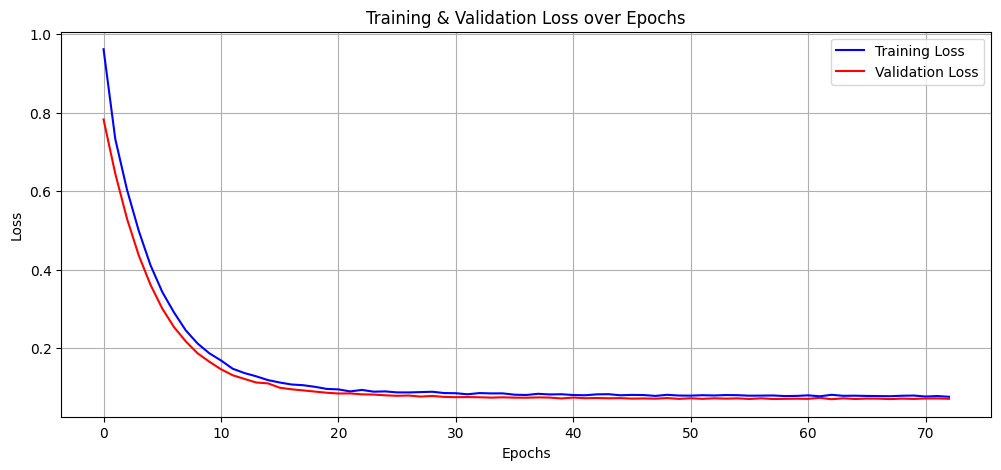

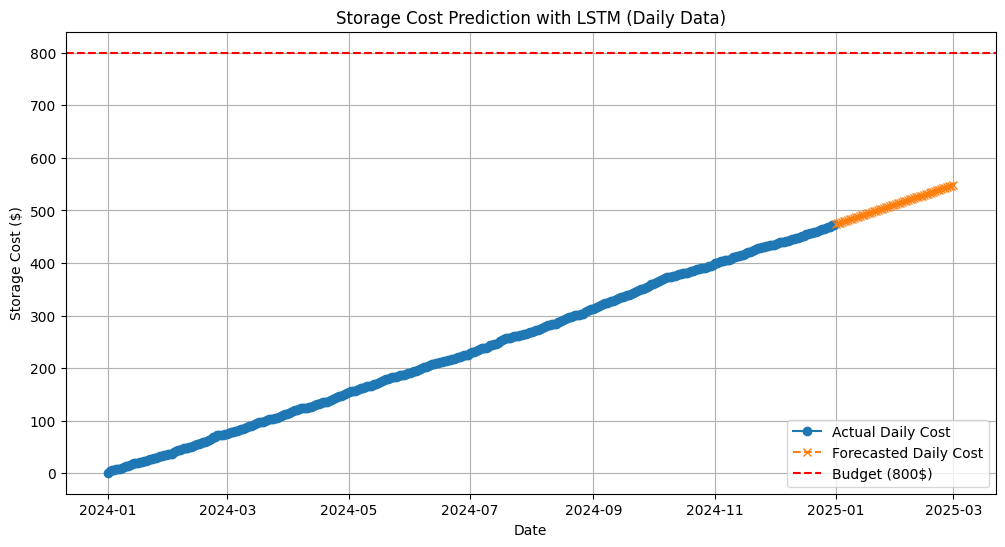

date 2025-03-01 00:00:00, value 548.5940551757812

 1년 단위 예측 스토리지 비용:
 Year  Predicted Cost ($)
 2025          472.776824
 2026          547.330505
 2027          547.330505
 2028          547.330505
 2029          547.330505


In [15]:
# 예산 도달 시점 계산
predicted_day = None
for i, cost in enumerate(forecast_cumulative[1:], start=1):
    if cost >= budget:
        predicted_day = i
        break

if predicted_day:
    predicted_date = data.index[-1] + pd.Timedelta(days=predicted_day)
    print(f"예산 {budget}$는 약 {predicted_day}일 후에 도달할 것으로 예측됩니다.")
    print(f"해당 날짜는 {predicted_date.strftime('%Y-%m-%d')}입니다.")
else:
    print(f"{forecast_steps}일 내에 예산 {budget}$에 도달하지 않을 것으로 예측됩니다.")

# 예측 정확도 계산
y_true = data['TotalCost'][-forecast_steps:]  # 실제값
y_pred = forecast_cumulative[1:len(y_true) + 1]  # 예측값
if len(y_true) > 0:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
else:
    print("예측 정확도를 계산할 충분한 데이터가 없습니다.")


# 추가 저장 시간 및 최적 비용 계산
V_s = 100  # 저장 볼륨 (GB)
C_s = 0.02  # 저장 비용 ($/GB)
T_min = 30  # 최소 저장 기간 (일)
omega_k = 0.8  # 읽기 가중치
V_k = 50  # 읽기 볼륨
R = 5  # 읽기 요청 횟수
C_r = 0.01  # 읽기 비용 ($)

def calculate_cost(t):
    T_lat = 0 if t % T_min == 0 else T_min - (t % T_min)
    base_cost = t * V_s * C_s
    latency_cost = T_lat * V_s * C_s if t > 0 else 0
    total_cost = base_cost + latency_cost
    return total_cost

time_range = np.arange(1, 365)
costs = [calculate_cost(t) + (omega_k * V_k * R * C_r) for t in time_range]
optimal_t = time_range[np.argmin(costs)]

print(f"최적 저장 기간: {optimal_t}일")
print(f"최소 비용: {min(costs):.4f} $")

# 학습 과정 시각화
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss over Epochs')
plt.legend()
plt.grid()
plt.show()


# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['TotalCost'], label='Actual Daily Cost', marker='o')
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
plt.plot(future_dates, forecast_cumulative[1:], label='Forecasted Daily Cost', marker='x', linestyle='--')
plt.axhline(y=budget, color='r', linestyle='--', label=f'Budget ({budget}$)')
if predicted_day:
    plt.axvline(x=predicted_date, color='g', linestyle='--', label=f'Predicted Date ({predicted_date.strftime("%Y-%m-%d")})')
plt.xlabel('Date')
#plt.ylim(0, 35000)
plt.ylabel('Storage Cost ($)')
plt.title('Storage Cost Prediction with LSTM (Daily Data)')
plt.legend()
plt.grid()
plt.show()

# 결과 출력
print("========================================")
print(f"date {future_dates[-1]}, value {forecast_cumulative[-1]}")

# 1년 단위 결과를 출력하는 표 생성
yearly_costs = []
current_year = data.index[-1].year  # 마지막 실제 데이터의 연도
base_date = data.index[-1]  # 예측 시작일

for i in range(1, 6):  # 5년 예측
    next_year = current_year + i
    next_year_date = pd.Timestamp(f"{next_year}-01-01")

    # 해당 연도에 가장 가까운 예측값 찾기
    closest_idx = np.argmin(np.abs(pd.Series(future_dates) - next_year_date))

    if closest_idx < len(forecast_cumulative):
        yearly_costs.append([next_year, forecast_cumulative[closest_idx]])

# Pandas DataFrame으로 변환하여 출력
yearly_cost_df = pd.DataFrame(yearly_costs, columns=["Year", "Predicted Cost ($)"])
print("\n 1년 단위 예측 스토리지 비용:")
print(yearly_cost_df.to_string(index=False))